In [1]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import socket
import glob
import os

In [10]:
if socket.gethostname() == 'Rohits-MBP':
    rootdir = '/Users/rohitchanne/Documents/capstone/data/data_parquet/'
else: 
    rootdir = '' # Enter your hone dir here

In [11]:
list_of_files = filter( os.path.isfile, glob.glob(rootdir + '*') )
files_with_size = [ file_path for file_path in list_of_files ]

In [12]:
dfs_parquet = {}
for file_path in files_with_size:
    if 'parquet' in file_path:
        file_name = file_path.split('/')[-1]
        df_name = file_name.split('_')[0]
        print(f'Reading Data File: {file_name}')       
        dfs_parquet[df_name] = pd.read_parquet(file_path, engine='pyarrow')

Reading Data File: Wednesday-21-02-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Friday-23-02-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Thuesday-20-02-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Thursday-22-02-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Friday-16-02-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Wednesday-28-02-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Wednesday-14-02-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Thursday-15-02-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Thursday-01-03-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Friday-02-03-2018_TrafficForML_CICFlowMeter_clean.parquet


In [28]:
dfs_parquet['Thuesday-20-02-2018'].drop(['Flow ID','Src IP','Src Port','Dst IP'], axis = 1, inplace=True)

In [13]:
for k,df in dfs_parquet.items():
    print(k)
    df['is_allowed'] = df['Label'] == 'Benign'
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Date'] = pd.to_datetime(df['Timestamp']).dt.date
    df['TS_relative'] = (df['Timestamp'].astype(int) - 
                                 pd.to_datetime(df['Date']).astype(int))/ 10**9
    df = df.drop(['Timestamp'], axis = 1)
    df = df.drop(['Date'], axis = 1)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    print(f'DF:{k}, Shape{df.shape}')

Wednesday-21-02-2018
DF:Wednesday-21-02-2018, Shape(1048575, 81)
Friday-23-02-2018
DF:Friday-23-02-2018, Shape(1048575, 81)
Thuesday-20-02-2018
DF:Thuesday-20-02-2018, Shape(7948748, 85)
Thursday-22-02-2018
DF:Thursday-22-02-2018, Shape(1048575, 81)
Friday-16-02-2018
DF:Friday-16-02-2018, Shape(1048574, 81)
Wednesday-28-02-2018
DF:Wednesday-28-02-2018, Shape(613071, 81)
Wednesday-14-02-2018
DF:Wednesday-14-02-2018, Shape(1048575, 81)
Thursday-15-02-2018
DF:Thursday-15-02-2018, Shape(1048575, 81)
Thursday-01-03-2018
DF:Thursday-01-03-2018, Shape(331100, 81)
Friday-02-03-2018
DF:Friday-02-03-2018, Shape(1048575, 81)


In [35]:
for k,df in dfs_parquet.items():
    print(f'DF:{k}, {df.groupby(["Label"]).size()}')

DF:Wednesday-21-02-2018, Label
Benign                  360833
DDOS attack-HOIC        686012
DDOS attack-LOIC-UDP      1730
dtype: int64
DF:Friday-23-02-2018, Label
Benign              1048009
Brute Force -Web        362
Brute Force -XSS        151
SQL Injection            53
dtype: int64
DF:Thuesday-20-02-2018, Label
Benign                    7372557
DDoS attacks-LOIC-HTTP     576191
dtype: int64
DF:Thursday-22-02-2018, Label
Benign              1048213
Brute Force -Web        249
Brute Force -XSS         79
SQL Injection            34
dtype: int64
DF:Friday-16-02-2018, Label
Benign                      446772
DoS attacks-Hulk            461912
DoS attacks-SlowHTTPTest    139890
dtype: int64
DF:Wednesday-28-02-2018, Label
Benign           544200
Infilteration     68871
dtype: int64
DF:Wednesday-14-02-2018, Label
Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
dtype: int64
DF:Thursday-15-02-2018, Label
Benign                   996077
DoS attacks-GoldenEye    

In [94]:
aggs = [ df.groupby(["Date","Label"]).size().reset_index() for _,df in dfs_parquet.items()]

In [95]:
aggs

[         Date                 Label       0
 0  2018-02-21                Benign  360833
 1  2018-02-21      DDOS attack-HOIC  686012
 2  2018-02-21  DDOS attack-LOIC-UDP    1730,
          Date             Label        0
 0  2018-02-23            Benign  1048009
 1  2018-02-23  Brute Force -Web      362
 2  2018-02-23  Brute Force -XSS      151
 3  2018-02-23     SQL Injection       53,
          Date                   Label        0
 0  2018-02-20                  Benign  7372557
 1  2018-02-20  DDoS attacks-LOIC-HTTP   576191,
          Date             Label        0
 0  1970-10-01            Benign        1
 1  1970-11-01            Benign        3
 2  1970-12-01            Benign        5
 3  2018-02-22            Benign  1048204
 4  2018-02-22  Brute Force -Web      249
 5  2018-02-22  Brute Force -XSS       79
 6  2018-02-22     SQL Injection       34,
          Date                     Label       0
 0  2018-02-16                    Benign  446772
 1  2018-02-16          DoS 

In [96]:
final_agg = pd.concat(aggs, ignore_index=True)

In [97]:
final_agg

,Date,Label,0
0,2018-02-21,Benign,360833
1,2018-02-21,DDOS attack-HOIC,686012
2,2018-02-21,DDOS attack-LOIC-UDP,1730
3,2018-02-23,Benign,1048009
4,2018-02-23,Brute Force -Web,362
5,2018-02-23,Brute Force -XSS,151
6,2018-02-23,SQL Injection,53
7,2018-02-20,Benign,7372557
8,2018-02-20,DDoS attacks-LOIC-HTTP,576191
9,1970-10-01,Benign,1


In [100]:
final_agg.sort_values(by = ["Date", "Label"], ascending=False)

,Date,Label,0
20,2018-02-28,Infilteration,68871
19,2018-02-28,Benign,544200
6,2018-02-23,SQL Injection,53
5,2018-02-23,Brute Force -XSS,151
4,2018-02-23,Brute Force -Web,362
3,2018-02-23,Benign,1048009
15,2018-02-22,SQL Injection,34
14,2018-02-22,Brute Force -XSS,79
13,2018-02-22,Brute Force -Web,249
12,2018-02-22,Benign,1048204


In [101]:
final_agg2 = final_agg.groupby(["Label"]).sum("count")

In [107]:
final_agg2

,0
Label,
Benign,13484708
Bot,286191
Brute Force -Web,611
Brute Force -XSS,230
DDOS attack-HOIC,686012
DDOS attack-LOIC-UDP,1730
DDoS attacks-LOIC-HTTP,576191
DoS attacks-GoldenEye,41508
DoS attacks-Hulk,461912


In [118]:
final_agg2.columns = ['Total Network Traffic']

In [122]:
final_agg2['Per Traffic'] = (final_agg2['Total Network Traffic'] / final_agg2['Total Network Traffic'].sum())*100

In [123]:
final_agg2.sort_values(by=['Total Network Traffic'],ascending=False)

,Total Network Traffic,Per Traffic
Label,,
Benign,13484708,83.070014
DDOS attack-HOIC,686012,4.226048
DDoS attacks-LOIC-HTTP,576191,3.549517
DoS attacks-Hulk,461912,2.845522
Bot,286191,1.763026
FTP-BruteForce,193360,1.191158
SSH-Bruteforce,187589,1.155607
Infilteration,161934,0.997564
DoS attacks-SlowHTTPTest,139890,0.861766


In [124]:
for k,df in dfs_parquet.items():
    print(k)
    df['hour'] = pd.to_datetime(df['Timestamp']).dt.hour

Wednesday-21-02-2018
Friday-23-02-2018
Thuesday-20-02-2018
Thursday-22-02-2018
Friday-16-02-2018
Wednesday-28-02-2018
Wednesday-14-02-2018
Thursday-15-02-2018
Thursday-01-03-2018
Friday-02-03-2018


In [133]:
agg_hour = [ df[["hour","is_allowed","Tot Fwd Pkts"]].groupby(["hour","is_allowed"]).sum("Tot Fwd Pkts").reset_index() for _,df in dfs_parquet.items()]

In [135]:
final_agg_hour = pd.concat(agg_hour, ignore_index=True)

In [140]:
pd.options.display.float_format = "{:,.2f}".format

In [142]:
temp_df = final_agg_hour.groupby(["hour","is_allowed"]).mean("Tot Fwd Pkts").reset_index()

In [144]:
temp_df['log_avg_hourly_packets'] = np.log2(temp_df['Tot Fwd Pkts'])

In [150]:
temp_df.columns = ["Hour of the day", "Is Benign", "Avg Packets", "Log Avg N/W Packets"]

In [146]:
import seaborn as sns

<AxesSubplot:xlabel='Hour of the day', ylabel='Log Avg N/W Packets'>

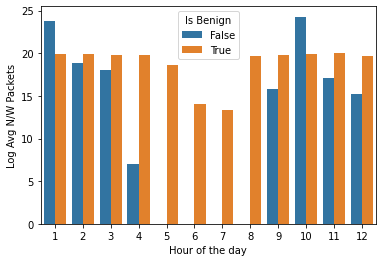

In [151]:
sns.barplot(x="Hour of the day",
            y="Log Avg N/W Packets",
            hue = "Is Benign",
            data=temp_df)